<a href="https://colab.research.google.com/github/morrowbord/ml_business/blob/main/colab_w2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

### Переходим к практике

Три ячейки ниже делаем в Google Colaboratory

- установим razdel
- установим pymorphy2

In [ ]:
!pip install razdel

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 7.8 MB/s 


In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 59 kB/s 
     |████████████████████████████████| 11.3 MB 40.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=e59852cf6e58aaba73fb2673c7f9ede78186b00a33470858de7c5bb8ebfbda05
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into

In [ ]:
!pip uninstall numpy
!pip uninstall pandas

!pip install --user numpy
!pip install --user  pandas

Делаем доступ к Googl Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Наши новости

In [ ]:
from google.colab import files

uploaded = files.upload()



In [3]:
import pandas as pd

In [ ]:
path = '/content/'

In [5]:
news = pd.read_csv("/content/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [ ]:
news.shape

(27000, 2)

Загрузим пользователей и списки последних прочитанных новостей

In [ ]:
users = pd.read_csv(path+"users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [ ]:
#from gensim.test.utils import common_texts
# https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/
from gensim.corpora.dictionary import Dictionary

In [ ]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer(  )

In [ ]:
len(stopword_ru)

151

In [ ]:
with open(path+'stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
stopword_ru[0]

'и'

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [ ]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [ ]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [ ]:
lemmatization(norm_text[0])

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',
 'норильский',
 'никель',
 'леонид',
 'исакович',
 '

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 25.8 s, sys: 1.2 s, total: 27 s
Wall time: 27 s


In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 9s, sys: 1.1 s, total: 4min 10s
Wall time: 4min 10s


А теперь в 3 строчки обучим нашу модель

In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [ ]:
common_dictionary[24]

'иванов'

In [ ]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'прессслужба',
 59: 'принять',
 

Делаем BoW по списку слов

In [ ]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(5, 3), (135645, 1), (135646, 1)]

In [ ]:
common_corpus[0][0]

(0, 2)

In [ ]:
len(texts[0])

113

Все просто - это словарь наших слов

Запускаем обучение

In [ ]:
N_topic = 20 # число тем - гиперпараметр

In [ ]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 48.8 s, sys: 24.9 s, total: 1min 13s
Wall time: 46.8 s


In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [ ]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.4891855),
 (1, 0.19220008),
 (2, 0.10120432),
 (5, 0.045928497),
 (18, 0.15273161)]

In [ ]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: проверка млн место мышь рекорд сон озеро золото первый второй третий хороший резидент извержение свидетель
topic_1: космос рейс фронт px затмение дождь народный гражданин украина атмосферный соцсеть adce первый tervertical разбираться
topic_2: россия путин всё новый день очень первый мир владимир век проект инвестиция снижение программа солнце
topic_3: самолёт корабль полёт двигатель доля управление экипаж борт авиакомпания скорость пассажир море новый первый система
topic_4: исследование выяснить банк пациент рак всё решение проблема общество россия спрос последствие российский иметь газета
topic_5: исследователь обнаружить тело препарат найти останки автомобиль днк марс летний пострадать производитель анализ кость удаться
topic_6: украина государственный россия область сотрудник совет депутат уголовный следствие расследование украинский наука документ вопрос член
topic_7: район исследование смерть помощь риск организм остров первый всё высота пострадать территория житель про

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [ ]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [ ]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(1, 0.37034005),
 (4, 0.14563067),
 (5, 0.13681883),
 (11, 0.047368146),
 (19, 0.27640483)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [ ]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.000000,0.037578,0.0,0.330868,0.014708,0.191189,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.419078,0.000000,0.0
1,4896,0.000000,0.400901,0.000000,0.0,0.000000,0.000000,0.034527,0.000000,0.000000,0.0,0.000000,0.0,0.54384,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,4897,0.489186,0.192203,0.101202,0.0,0.000000,0.045927,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.152732,0.0
3,4898,0.000000,0.146457,0.157342,0.0,0.000000,0.000000,0.000000,0.350909,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.335536,0.000000,0.0
4,4899,0.000000,0.101482,0.000000,0.0,0.000000,0.000000,0.376107,0.000000,0.437735,0.0,0.063054,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [ ]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.000000,0.037578,0.0,0.330868,0.014708,0.191189,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.419078,0.000000,0.0
1,4896,0.000000,0.400901,0.000000,0.0,0.000000,0.000000,0.034527,0.000000,0.000000,0.0,0.000000,0.0,0.54384,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,4897,0.489186,0.192203,0.101202,0.0,0.000000,0.045927,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.152732,0.0
3,4898,0.000000,0.146457,0.157342,0.0,0.000000,0.000000,0.000000,0.350909,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.335536,0.000000,0.0
4,4899,0.000000,0.101482,0.000000,0.0,0.000000,0.000000,0.376107,0.000000,0.437735,0.0,0.063054,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [ ]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [ ]:
doc_dict[293622]

array([0.01478453, 0.        , 0.13369904, 0.        , 0.01471012,
       0.        , 0.        , 0.01509659, 0.22472747, 0.0332141 ,
       0.1198971 , 0.        , 0.01927858, 0.04163546, 0.07948869,
       0.2219872 , 0.        , 0.        , 0.        , 0.07722582])

In [ ]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.max(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [ ]:
user_articles_list = users['articles'].iloc[33]

In [ ]:
vv = get_user_embedding(user_articles_list)
vv

array([0.        , 0.        , 0.05097773, 0.        , 0.        ,
       0.        , 0.09680148, 0.        , 0.        , 0.        ,
       0.12827675, 0.        , 0.01161493, 0.14934967, 0.        ,
       0.        , 0.00617577, 0.02581399, 0.        , 0.05573688])

In [ ]:
import matplotlib.pyplot as plt

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [ ]:
#users['articles'].iloc[33]

In [ ]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.000000,0.102402,0.000000,0.000000,0.0,0.010494,0.000000,0.000000,0.0,0.070529,0.0,0.036209,0.015870,0.214699,0.042462,0.000000,0.000000,0.0,0.037670
1,u108690,0.0,0.013304,0.025333,0.000000,0.074439,0.0,0.133977,0.078143,0.007158,0.0,0.101339,0.0,0.008357,0.050499,0.047758,0.011302,0.000000,0.012640,0.0,0.021743
2,u108339,0.0,0.000000,0.030129,0.009201,0.041115,0.0,0.108565,0.077876,0.000000,0.0,0.086303,0.0,0.067064,0.009167,0.093328,0.000000,0.031202,0.005506,0.0,0.025914


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv(path+"users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.000000,0.102402,0.000000,0.000000,0.0,0.010494,0.000000,0.000000,0.0,0.070529,0.0,0.036209,0.015870,0.214699,0.042462,0.000000,0.000000,0.0,0.037670,0
1,u108690,0.0,0.013304,0.025333,0.000000,0.074439,0.0,0.133977,0.078143,0.007158,0.0,0.101339,0.0,0.008357,0.050499,0.047758,0.011302,0.000000,0.012640,0.0,0.021743,1
2,u108339,0.0,0.000000,0.030129,0.009201,0.041115,0.0,0.108565,0.077876,0.000000,0.0,0.086303,0.0,0.067064,0.009167,0.093328,0.000000,0.031202,0.005506,0.0,0.025914,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [ ]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07618609, 0.05158796, 0.30510069, 0.20679901, 0.10256751,
       0.10743872, 0.07650306, 0.03586831, 0.08324842, 0.16659362])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

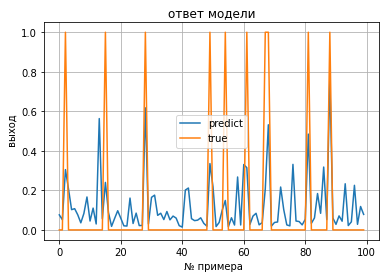

In [ ]:

plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

In [ ]:

precision, recall, thresholds = precision_recall_curve(y_test.values, preds)


In [ ]:
n=-1
fscore = (2 * precision[:n] * recall[:n]) / (precision[:n] + recall[:n])

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.285307, F-Score=0.724, Precision=0.691, Recall=0.759


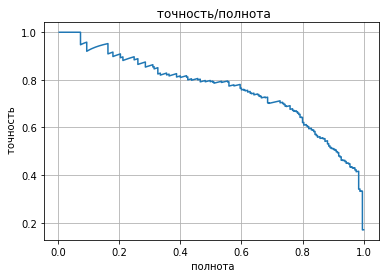

In [ ]:
plt.plot(recall[:n],precision[:n] )
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1672   83]
 [  60  185]]


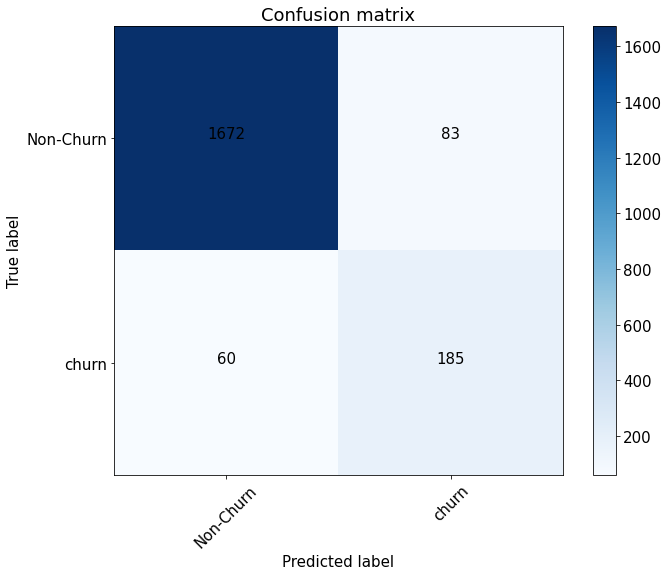

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test, preds)

0.9581184952613524

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans


In [ ]:
import seaborn as sns

In [ ]:
X_train.shape

(6000, 20)

In [ ]:
kmeans = KMeans(n_clusters=N_topic)
kmeans.fit(X_train)
y_kmeans = kmeans.predict(X_train)


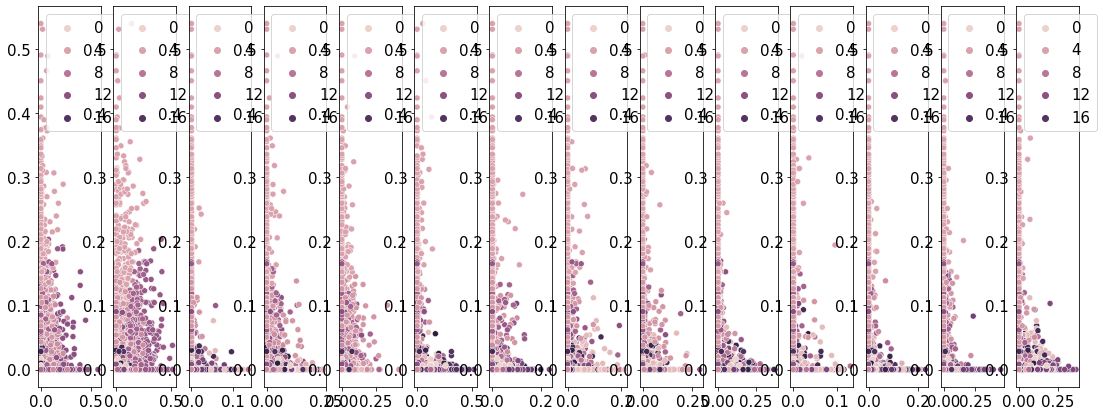

In [ ]:
nn = N_topic-5
plt.figure(figsize= (20,7))
for i in range(1,nn):
  plt.subplot(1,nn,i)
  sns.scatterplot(x= X_train.iloc[:,i].values, y = X_train.iloc[:,0].values,hue = y_kmeans)
plt.show()

In [ ]:
EPS = []
for eps in np.linspace(0.01,1.0,50):
  x_cluster = DBSCAN(eps=eps, min_samples=15).fit(X_train)
  EPS.append([eps,len(set(x_cluster.labels_)),np.sum(x_cluster.labels_ == -1)])
EPS = np.array(EPS)



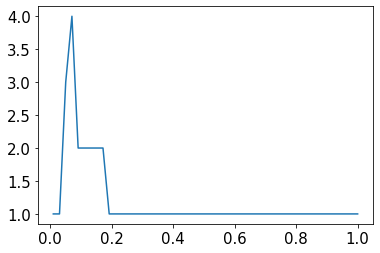

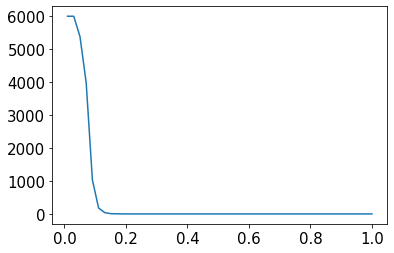

In [ ]:
plt.plot(EPS[:,0],EPS[:,1])
plt.show()
plt.plot(EPS[:,0],EPS[:,2])
plt.show()  


In [ ]:
ind = np.where((EPS[:,1]>2)&(EPS[:,2]<1000))[0]
EPS[ind,:]

array([], shape=(0, 3), dtype=float64)

In [ ]:
x_cluster = DBSCAN(eps=0.5, min_samples=15).fit(X_train)
print('число не группируемых клиентов (выбросов): ',len(np.where(x_cluster.labels_<0)[0]))
print('число групп: ',len(set(x_cluster.labels_)))

число не группируемых клиентов (выбросов):  1300
число групп:  3


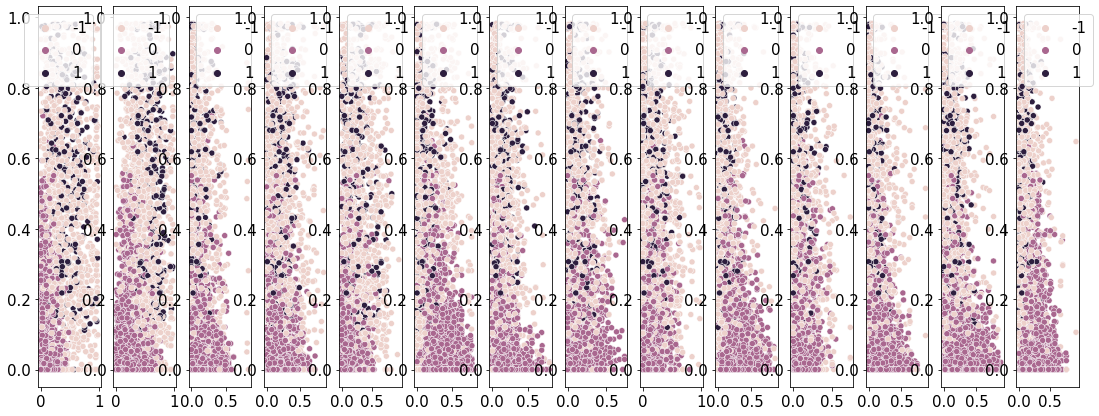

In [ ]:
nn = N_topic-5
plt.figure(figsize= (20,7))
for i in range(1,nn):
  plt.subplot(1,nn,i)
  sns.scatterplot(x= X_train.iloc[:,i].values, y = X_train.iloc[:,0].values,hue = x_cluster.labels_)
plt.show()


In [ ]:
clustering = AgglomerativeClustering( n_clusters=N_topic)
c_clast  = clustering.fit_predict(X_train)

In [ ]:
c_clast[:10]

array([ 1,  7,  9,  0,  0,  2,  5,  5,  4, 10])

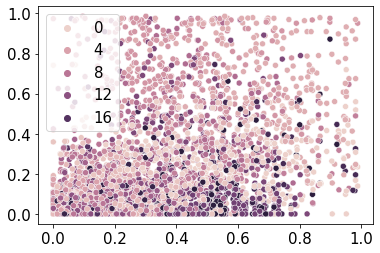

In [ ]:

sns.scatterplot(x= X_train.iloc[:,2].values, y = X_train.iloc[:,1].values,hue = c_clast)

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

# **1 **
tf, показывает как часто слово встречается в тексте, idf покажет как часто слово встечается во всех документах - путем вычисления произведения tf и idf получаем вес слова, чем выше вес - тем реже слово встречается и тем слово важнее.

In [ ]:
# 2 задача
# median вместо mean
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.median(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

    # Best Threshold=0.285307, F-Score=0.724, Precision=0.691, Recall=0.759

In [1]:
#случай max
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.max(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector
    